In [63]:
import numpy as np
import pandas as pd 
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
from attention_3 import AttentionLayer

In [64]:
data = pd.read_csv('Reviews.csv'); data

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
...,...,...,...,...,...,...,...,...,...,...
568449,568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,5,1299628800,Will not do without,Great for sesame chicken..this is a good if no...
568450,568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,2,1331251200,disappointed,I'm disappointed with the flavor. The chocolat...
568451,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,5,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o..."
568452,568453,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,5,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rew...


In [65]:
data.drop_duplicates(subset=['Text'],inplace=True)#dropping duplicates
data.dropna(axis=0,inplace=True)#dropping na
print(f"No of datapoints after dropping duplicates and NA Values is {len(data)}.")#checking number of remaining datapoints

No of datapoints after dropping duplicates and NA Values is 393565.


In [66]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 393565 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      393565 non-null  int64 
 1   ProductId               393565 non-null  object
 2   UserId                  393565 non-null  object
 3   ProfileName             393565 non-null  object
 4   HelpfulnessNumerator    393565 non-null  int64 
 5   HelpfulnessDenominator  393565 non-null  int64 
 6   Score                   393565 non-null  int64 
 7   Time                    393565 non-null  int64 
 8   Summary                 393565 non-null  object
 9   Text                    393565 non-null  object
dtypes: int64(5), object(5)
memory usage: 33.0+ MB


In [67]:
print(data.loc[:,'Text'][0])
print(data.loc[:,'Summary'][0])

I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.
Good Quality Dog Food


In [68]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [69]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
rem  = []
for i in stop_words:
    l1 = i[-3:]
    l2 = i[-1:]
    if (l1 == "n't"):
        rem.append(i)
    elif (l2 == "n"):
        rem.append(i)
#print(rem)  
stop_words = stop_words - set(rem)-set(['not', 'no', 'nor'])
print(stop_words)

{'who', 'there', 'below', 'our', 'of', 'each', 'my', 'at', 's', 'to', 'she', 'its', 'her', 'will', 'other', 'was', 'their', "you're", 'through', 'have', 'where', 'these', "it's", 'by', 'only', 'too', "you'll", 'yours', 'hers', 'most', 've', 'any', 'as', 'did', 'this', 'up', 'were', 'about', 'so', 'against', 'having', 'how', 'am', 'under', 'yourself', 'y', 'ourselves', 'during', 'few', 't', 'above', 're', 'same', 'he', 'himself', 'doing', 'because', 'itself', "you've", 'if', 'more', 'herself', 'his', 'has', "you'd", 'once', 'further', 'just', 'some', 'from', 'we', 'ours', 'which', 'them', 'while', 'such', 'here', 'is', 'why', 'what', 'be', 'a', 'me', 'until', 'you', 'they', 'both', "that'll", 'whom', 'll', 'myself', 'should', 'before', "should've", 'being', 'but', 'your', 'after', 'the', 'ma', 'had', 'i', 'it', 'd', 'm', "she's", 'themselves', 'do', 'those', 'yourselves', 'are', 'over', 'and', 'him', 'theirs', 'with', 'o', 'very', 'all', 'does', 'or', 'that', 'out', 'now', 'off', 'for',

[nltk_data] Downloading package stopwords to /home/sysadm/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [70]:
def cleaner(text,num):
    newString = text.lower()                                                                                                 #Converting everything to lowercase
    #newString = BeautifulSoup(newString, "lxml").text                                                                        #Remove XML & HTML tags
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])          #Expanding Contractions
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    newString = re.sub('[m]{2,}', 'mm', newString)
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]                                                      #removing stopwords
    else:
        tokens=newString.split()
        
    long_words=[]
    for i in tokens:
        if len(i)>1:                                                                                                        #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

In [71]:
cleaned_text = []
for t in data['Text']:
    cleaned_text.append(cleaner(t,0))

In [72]:
print(data.loc[:,'Text'][0])
print(cleaned_text[:1])  

I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.
['bought several vitality canned dog food products found good quality product looks like stew than processed meat smells better labrador finicky appreciates product better than']


In [73]:
cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(cleaner(t,1))

In [74]:
print(data.loc[:,'Summary'][0])
print(cleaned_summary[:1])

Good Quality Dog Food
['good quality dog food']


In [75]:
data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary
print(data.loc[:,'Text'][0])
print(data.loc[:,'cleaned_text'][0])
print(data.loc[:,'Summary'][0])
print(data.loc[:,'cleaned_summary'][0])

I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.
bought several vitality canned dog food products found good quality product looks like stew than processed meat smells better labrador finicky appreciates product better than
Good Quality Dog Food
good quality dog food


In [76]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleaned_text,cleaned_summary
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,bought several vitality canned dog food produc...,good quality dog food
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,product arrived labeled jumbo salted peanuts p...,not as advertised
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,confection been around centuries light pillowy...,delight says it all
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,looking secret ingredient in robitussin believ...,cough medicine
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,great taffy great price wide assortment yummy ...,great taffy


In [77]:
data.replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

In [78]:
len(data)

393217

In [79]:
from matplotlib.pyplot import figure

<Figure size 640x480 with 0 Axes>

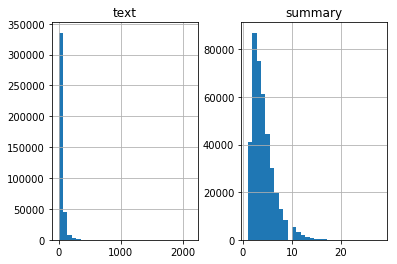

In [80]:
import matplotlib.pyplot as plt
figure(figsize=(8, 6), dpi=80)
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

In [81]:
cnt=0
for i in data['cleaned_text']:
    if(len(i.split())<=40):
        cnt=cnt+1
print(cnt/len(data['cleaned_text']))

0.6397968551715719


In [82]:
cnt=0
for i in data['cleaned_summary']:
    if(len(i.split())<=8):
        cnt=cnt+1
print(cnt/len(data['cleaned_summary']))

0.9457805740850472


In [83]:
max_text_len=25
max_summary_len=8

In [84]:
cleaned_text =np.array(data['cleaned_text'])
cleaned_summary=np.array(data['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
df=pd.DataFrame({'text':short_text,'summary':short_summary})
df

,text,summary
0,bought several vitality canned dog food produc...,good quality dog food
1,product arrived labeled jumbo salted peanuts p...,not as advertised
2,looking secret ingredient in robitussin believ...,cough medicine
3,great taffy great price wide assortment yummy ...,great taffy
4,taffy good soft chewy flavors amazing would de...,wonderful tasty taffy
...,...,...
157829,complaint much not use huge amount spice gave ...,very large ground spice jars
157830,great sesame chicken good not better than rest...,will not do without
157831,disappointed flavor chocolate notes especially...,disappointed
157832,best treats training rewarding dog good groomi...,favorite training and reward treat


In [85]:
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok'); df

,text,summary
0,bought several vitality canned dog food produc...,sostok good quality dog food eostok
1,product arrived labeled jumbo salted peanuts p...,sostok not as advertised eostok
2,looking secret ingredient in robitussin believ...,sostok cough medicine eostok
3,great taffy great price wide assortment yummy ...,sostok great taffy eostok
4,taffy good soft chewy flavors amazing would de...,sostok wonderful tasty taffy eostok
...,...,...
157829,complaint much not use huge amount spice gave ...,sostok very large ground spice jars eostok
157830,great sesame chicken good not better than rest...,sostok will not do without eostok
157831,disappointed flavor chocolate notes especially...,sostok disappointed eostok
157832,best treats training rewarding dog good groomi...,sostok favorite training and reward treat eostok


In [86]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['text']),np.array(df['summary']),
                                       test_size=0.1,random_state=0,shuffle=False)

In [87]:
list(x_tr)[0]

'bought several vitality canned dog food products found good quality product looks like stew than processed meat smells better labrador finicky appreciates product better than'

In [88]:
list(y_tr)[0]

'sostok good quality dog food eostok'

In [89]:
from keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences

#prepare a tokenizer for text on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

In [90]:
x_tokenizer.word_counts.items()

odict_items([('bought', 7048), ('several', 1948), ('vitality', 15), ('canned', 666), ('dog', 5432), ('food', 6827), ('products', 2971), ('found', 5898), ('good', 33136), ('quality', 4688), ('product', 25202), ('looks', 759), ('like', 26159), ('stew', 79), ('than', 11503), ('processed', 220), ('meat', 845), ('smells', 1013), ('better', 8489), ('labrador', 36), ('finicky', 182), ('appreciates', 19), ('arrived', 3872), ('labeled', 86), ('jumbo', 51), ('salted', 225), ('peanuts', 509), ('actually', 1812), ('small', 2868), ('sized', 318), ('unsalted', 71), ('not', 55769), ('sure', 2659), ('an', 6963), ('error', 66), ('vendor', 441), ('intended', 75), ('represent', 12), ('looking', 2887), ('secret', 110), ('ingredient', 465), ('in', 49729), ('robitussin', 2), ('believe', 911), ('got', 4521), ('addition', 618), ('root', 191), ('beer', 323), ('extract', 356), ('ordered', 4856), ('made', 4560), ('cherry', 564), ('soda', 658), ('flavor', 18652), ('medicinal', 49), ('great', 36267), ('taffy', 184

In [91]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("% of Total Coverage of rare words:",(freq/tot_freq)*100)
print(freq)
print(tot_freq)

% of rare words in vocabulary: 65.48219509734692
% of Total Coverage of rare words: 1.4980469444671098
35801
2389845


In [92]:
#prepare a tokenizer for text on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

In [93]:
x_tr_seq[1]

[6,
 96,
 2516,
 3398,
 1335,
 740,
 740,
 249,
 147,
 1034,
 2797,
 1,
 162,
 41,
 2926,
 828,
 2726,
 7297,
 6,
 3398]

In [94]:
x_tr[1]

array([   6,   96, 2516, 3398, 1335,  740,  740,  249,  147, 1034, 2797,
          1,  162,   41, 2926,  828, 2726, 7297,    6, 3398,    0,    0,
          0,    0,    0], dtype=int32)

In [95]:
x_voc

13688

In [96]:
#prepare a tokenizer for summary on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

In [97]:
x_tokenizer.word_counts.items()

odict_items([('bought', 7048), ('several', 1948), ('vitality', 15), ('canned', 666), ('dog', 5432), ('food', 6827), ('products', 2971), ('found', 5898), ('good', 33136), ('quality', 4688), ('product', 25202), ('looks', 759), ('like', 26159), ('stew', 79), ('than', 11503), ('processed', 220), ('meat', 845), ('smells', 1013), ('better', 8489), ('labrador', 36), ('finicky', 182), ('appreciates', 19), ('arrived', 3872), ('labeled', 86), ('jumbo', 51), ('salted', 225), ('peanuts', 509), ('actually', 1812), ('small', 2868), ('sized', 318), ('unsalted', 71), ('not', 55769), ('sure', 2659), ('an', 6963), ('error', 66), ('vendor', 441), ('intended', 75), ('represent', 12), ('looking', 2887), ('secret', 110), ('ingredient', 465), ('in', 49729), ('robitussin', 2), ('believe', 911), ('got', 4521), ('addition', 618), ('root', 191), ('beer', 323), ('extract', 356), ('ordered', 4856), ('made', 4560), ('cherry', 564), ('soda', 658), ('flavor', 18652), ('medicinal', 49), ('great', 36267), ('taffy', 184

In [98]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("% of Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 69.34402749928388
% of Total Coverage of rare words: 2.2909624162644837


In [99]:
#prepare a tokenizer for summary on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

In [100]:
y_tokenizer.word_counts['sostok'],len(y_tr)

(142050, 142050)

In [101]:
y_voc

5352

In [102]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [103]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

In [104]:
from keras import backend as K 

In [105]:
K.clear_session()

latent_dim = 200
embedding_dim = 300

# Encoder
encoder_inputs = Input(shape = (max_text_len, ))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim, trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim, return_sequences = True, return_state = True)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim, return_sequences = True, return_state = True)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3 = LSTM(latent_dim, return_state = True, return_sequences = True)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape = (None, ))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim, trainable = True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences = True, return_state = True)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state = [state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name = 'attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis = -1,name = 'concat_layer')([decoder_outputs, attn_out])

# Dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation = 'softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary() 

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 25)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 25, 300)      4106400     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 25, 200), (N 400800      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [106]:
model.compile(optimizer = 'rmsprop', loss ='sparse_categorical_crossentropy', metrics = ['acc'])

In [107]:
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 2)

In [108]:
history=model.fit([x_tr, y_tr[:,:-1]], 
                  y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:, 1:],
                  epochs = 50,
                  callbacks = [es],
                  batch_size = 128, 
                  validation_split = 0.1)

Epoch 1/50
985/985 [==============================] - 401s 398ms/step - loss: 2.6787 - acc: 0.6022 - val_loss: 2.4163 - val_acc: 0.6295
Epoch 2/50
985/985 [==============================] - 389s 395ms/step - loss: 2.3197 - acc: 0.6328 - val_loss: 2.2693 - val_acc: 0.6411
Epoch 3/50
985/985 [==============================] - 397s 403ms/step - loss: 2.1933 - acc: 0.6447 - val_loss: 2.1904 - val_acc: 0.6497
Epoch 4/50
985/985 [==============================] - 384s 390ms/step - loss: 2.1108 - acc: 0.6517 - val_loss: 2.1435 - val_acc: 0.6537
Epoch 5/50
985/985 [==============================] - 386s 391ms/step - loss: 2.0501 - acc: 0.6575 - val_loss: 2.1192 - val_acc: 0.6567
Epoch 6/50
985/985 [==============================] - 374s 380ms/step - loss: 2.0050 - acc: 0.6624 - val_loss: 2.1089 - val_acc: 0.6570
Epoch 7/50
985/985 [==============================] - 374s 380ms/step - loss: 1.9651 - acc: 0.6661 - val_loss: 2.0924 - val_acc: 0.6600
Epoch 8/50
985/985 [============================

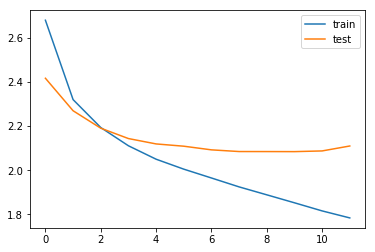

In [109]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [110]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word

target_word_index=y_tokenizer.word_index

In [111]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs = encoder_inputs, outputs = [encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape = (latent_dim, ))
decoder_state_input_c = Input(shape = (latent_dim, ))
decoder_hidden_state_input = Input(shape = (max_text_len, latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2 = dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state = [decoder_state_input_h, decoder_state_input_c])

#Attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis = -1, name = 'concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [112]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ""
    
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += sampled_token + " "

        # Exit condition: either hit max length or find stop word.
        if(sampled_token == 'eostok' or len(decoded_sentence.split()) >= (max_summary_len - 1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [113]:
def seq2summary(input_seq):
    newString = ""
    for i in input_seq:
        if((i != 0 and i!= target_word_index['sostok']) and i!= target_word_index['eostok']):
            newString += reverse_target_word_index[i] + " "
    return newString

def seq2text(input_seq):
    newString = ""
    for i in input_seq:
        if(i != 0):
            newString += reverse_source_word_index[i] + " "
    return newString

In [114]:
from scipy import spatial
import gensim.downloader as api

In [115]:
model = api.load("glove-wiki-gigaword-50")

def preprocess(s):
    return [i.lower() for i in s.split()]

def get_vector(s):
    return np.sum(np.array([model[i] for i in preprocess(s)]), axis=0)

In [116]:
rand_ind = np.random.randint(0, 500000, size = 5000)
cnt = 0
tot_sim  = 0

In [117]:
for i in rand_ind:
    try:
        #print("Review:", seq2text(x_tr[i]))
        og_sum = seq2summary(y_tr[i])
        op_sum = decode_sequence(x_tr[i].reshape(1,max_text_len))
        sim = 1 - spatial.distance.cosine(get_vector(og_sum), get_vector(op_sum))
        sim = abs(sim)
        tot_sim = tot_sim + sim
        cnt = cnt + 1
        print("Original summary:", og_sum)
        print("Predicted summary:", op_sum)
        print("Semantic Similarity:", sim)      
        print("\n")
    except:
        continue

Original summary: little disappointed 
Predicted summary: not what expected 
Semantic Similarity: 0.8456689119338989


Original summary: he loves them but 
Predicted summary: dog loves it 
Semantic Similarity: 0.8804680109024048


Original summary: our dog love this 
Predicted summary: my dog loves it 
Semantic Similarity: 0.9580510258674622


Original summary: availability 
Predicted summary: candy 
Semantic Similarity: 0.13071408867835999


Original summary: wonderful pepper 
Predicted summary: great product 
Semantic Similarity: 0.5533086061477661


Original summary: love newman own products 
Predicted summary: great food 
Semantic Similarity: 0.8182225823402405


Original summary: super soups fantastic 
Predicted summary: delicious 
Semantic Similarity: 0.6737104654312134


Original summary: love it 
Predicted summary: love this tea 
Semantic Similarity: 0.9157773852348328


Original summary: jellies jams are great stuff 
Predicted summary: great taste 
Semantic Similarity: 0.75601

Original summary: wedding 
Predicted summary: great 
Semantic Similarity: 0.4326907992362976


Original summary: just like skyline chilli it is delicious 
Predicted summary: great stuff 
Semantic Similarity: 0.8531185388565063


Original summary: li hing mui powder 
Predicted summary: delicious 
Semantic Similarity: 0.052372775971889496


Original summary: very good honey 
Predicted summary: best honey ever 
Semantic Similarity: 0.9120932221412659


Original summary: chewing good 
Predicted summary: best licorice 
Semantic Similarity: 0.7564079165458679


Original summary: peanuts 
Predicted summary: best peanuts ever 
Semantic Similarity: 0.6119165420532227


Original summary: in orbit 
Predicted summary: best gum ever 
Semantic Similarity: 0.5488322377204895


Original summary: disappointed 
Predicted summary: not worth it 
Semantic Similarity: 0.5954060554504395


Original summary: closest to real pasta have found 
Predicted summary: great pasta 
Semantic Similarity: 0.7189954519271

Original summary: great gift 
Predicted summary: perfect 
Semantic Similarity: 0.7006513476371765


Original summary: love to buy serve give for gifts 
Predicted summary: great tea 
Semantic Similarity: 0.719028651714325


Original summary: addictive 
Predicted summary: love these 
Semantic Similarity: 0.3264569640159607


Original summary: tully house blend cup coffee 
Predicted summary: coffee 
Semantic Similarity: 0.8033444285392761


Original summary: great color and taste 
Predicted summary: great taste 
Semantic Similarity: 0.9305174350738525


Original summary: another winner for chex mix 
Predicted summary: cookies 
Semantic Similarity: 0.4173469543457031


Original summary: disgusting 
Predicted summary: not what expected 
Semantic Similarity: 0.2158513218164444


Original summary: not so good 
Predicted summary: not worth the money 
Semantic Similarity: 0.8929249048233032


Original summary: not much coffee taste 
Predicted summary: good stuff 
Semantic Similarity: 0.86679053

Original summary: hazelnut manner wafers 
Predicted summary: great taste 
Semantic Similarity: 0.3871813416481018


Original summary: super quick appetizer 
Predicted summary: great sauce 
Semantic Similarity: 0.7047395706176758


Original summary: great product 
Predicted summary: great product 
Semantic Similarity: 1


Original summary: barley malt has gluten 
Predicted summary: gluten free baking 
Semantic Similarity: 0.7247529625892639


Original summary: tastes great 
Predicted summary: great taste 
Semantic Similarity: 0.9508131742477417


Original summary: love it 
Predicted summary: the best 
Semantic Similarity: 0.8419368267059326


Original summary: wow love these 
Predicted summary: yummy 
Semantic Similarity: 0.21856631338596344


Original summary: perfect 
Predicted summary: perfect 
Semantic Similarity: 1


Original summary: loose oolong tea pound bag 
Predicted summary: not what expected 
Semantic Similarity: 0.38679391145706177


Original summary: the best raisins ever 

Original summary: grainy sugar 
Predicted summary: not what expected 
Semantic Similarity: 0.26558810472488403


Original summary: very tasty 
Predicted summary: great taste 
Semantic Similarity: 0.7949533462524414


Original summary: one of my all time favorites 
Predicted summary: my favorite coffee 
Semantic Similarity: 0.8336198925971985


Original summary: great product 
Predicted summary: good product 
Semantic Similarity: 0.930661141872406


Original summary: great deal and quality 
Predicted summary: great price 
Semantic Similarity: 0.8786131143569946


Original summary: love this dip 
Predicted summary: the best 
Semantic Similarity: 0.8219285011291504


Original summary: tasty crisp tangy ginger cookies 
Predicted summary: delicious 
Semantic Similarity: 0.8836733102798462


Original summary: best ever snack 
Predicted summary: great snack 
Semantic Similarity: 0.8685839176177979


Original summary: stevia is great sugar alternative 
Predicted summary: best stevia 
Semantic 

Original summary: very tasty 
Predicted summary: great taste 
Semantic Similarity: 0.7949533462524414


Original summary: best tea at the best price 
Predicted summary: great price 
Semantic Similarity: 0.8841992020606995


Original summary: fantastic 
Predicted summary: delicious 
Semantic Similarity: 0.46757781505584717


Original summary: great stuff 
Predicted summary: great stuff 
Semantic Similarity: 1


Original summary: the wonder coffee 
Predicted summary: taste like coffee 
Semantic Similarity: 0.8867230415344238


Original summary: best of the best 
Predicted summary: best of the best 
Semantic Similarity: 1


Original summary: cuban fuel from miami 
Predicted summary: not worth it 
Semantic Similarity: 0.7337548732757568


Original summary: delicious and nutritious 
Predicted summary: love it 
Semantic Similarity: 0.5930584073066711


Original summary: ok 
Predicted summary: not for me 
Semantic Similarity: 0.7235252261161804


Original summary: the best salmon have ever ea

Original summary: amazing for the money 
Predicted summary: great product 
Semantic Similarity: 0.8789005875587463


Original summary: good fast cup 
Predicted summary: good coffee 
Semantic Similarity: 0.8208684921264648


Original summary: dog loves them 
Predicted summary: my dog loves these 
Semantic Similarity: 0.9620352387428284


Original summary: cheaper than other brands 
Predicted summary: great product 
Semantic Similarity: 0.7905343770980835


Original summary: wasa and 
Predicted summary: great 
Semantic Similarity: 0.5567451119422913


Original summary: my cats soooo love this 
Predicted summary: cats love it 
Semantic Similarity: 0.9473658204078674


Original summary: the best stuff to use 
Predicted summary: great product 
Semantic Similarity: 0.8763959407806396


Original summary: great flavor 
Predicted summary: great candy 
Semantic Similarity: 0.8464908599853516


Original summary: their teabags are sweeter 
Predicted summary: tea 
Semantic Similarity: 0.51800256967

Original summary: great smooth tasting coffee 
Predicted summary: great coffee 
Semantic Similarity: 0.9166117906570435


Original summary: terrible 
Predicted summary: horrible 
Semantic Similarity: 0.9373438358306885


Original summary: great meatloaf 
Predicted summary: not what expected 
Semantic Similarity: 0.45994827151298523


Original summary: wonderful coffee 
Predicted summary: great coffee 
Semantic Similarity: 0.8983718752861023


Original summary: training treats 
Predicted summary: dog treats 
Semantic Similarity: 0.6673458814620972


Original summary: my favorite coffee 
Predicted summary: great coffee 
Semantic Similarity: 0.8768559694290161


Original summary: works well 
Predicted summary: good product 
Semantic Similarity: 0.79945969581604


Original summary: different flavor 
Predicted summary: not very good 
Semantic Similarity: 0.7425825595855713


Original summary: bad coffee 
Predicted summary: worst coffee ever 
Semantic Similarity: 0.8856543302536011


Origina

Original summary: super pez 
Predicted summary: cute 
Semantic Similarity: 0.2599603533744812


Original summary: little tinny 
Predicted summary: not the best 
Semantic Similarity: 0.5435811281204224


Original summary: perfect 
Predicted summary: perfect 
Semantic Similarity: 1


Original summary: yuk 
Predicted summary: yuck 
Semantic Similarity: 0.40034204721450806


Original summary: yum 
Predicted summary: delicious 
Semantic Similarity: 0.18168184161186218


Original summary: bread flour 
Predicted summary: great product 
Semantic Similarity: 0.3976789712905884


Original summary: met all expectations 
Predicted summary: gift 
Semantic Similarity: 0.4518551826477051


Original summary: very good for treat 
Predicted summary: good but 
Semantic Similarity: 0.9561634063720703


Original summary: great seasoning 
Predicted summary: great seasoning 
Semantic Similarity: 1


Original summary: dogs love rise and shine 
Predicted summary: dog loves it 
Semantic Similarity: 0.8537076711

Original summary: kid favorite snack drink for the summer 
Predicted summary: not bad but not great 
Semantic Similarity: 0.7907152771949768


Original summary: love it 
Predicted summary: great mustard 
Semantic Similarity: 0.6245498657226562


Original summary: yum yum yum 
Predicted summary: my dog loves these 
Semantic Similarity: 0.08854588866233826


Original summary: the good stuff 
Predicted summary: great product 
Semantic Similarity: 0.8713465332984924


Original summary: chocolate delight 
Predicted summary: best chocolate ever 
Semantic Similarity: 0.7076616287231445


Original summary: food 
Predicted summary: great product 
Semantic Similarity: 0.6670140027999878


Original summary: my dogs love these 
Predicted summary: great product 
Semantic Similarity: 0.7571893930435181


Original summary: only calories 
Predicted summary: great taste 
Semantic Similarity: 0.5637581944465637


Original summary: delicious granola bars great value 
Predicted summary: great granola bars

Original summary: nice 
Predicted summary: good for you 
Semantic Similarity: 0.7561511993408203


Original summary: good price for excellent cat food 
Predicted summary: great price 
Semantic Similarity: 0.8722651600837708


Original summary: unpleasant aftertaste 
Predicted summary: not good 
Semantic Similarity: 0.2835519313812256


Original summary: great coffee 
Predicted summary: great coffee 
Semantic Similarity: 1


Original summary: cute tins low quality tea 
Predicted summary: great product 
Semantic Similarity: 0.6933915019035339


Original summary: tasty 
Predicted summary: good snack 
Semantic Similarity: 0.6942436099052429


Original summary: great mints 
Predicted summary: great mints 
Semantic Similarity: 1


Original summary: pet food 
Predicted summary: great food 
Semantic Similarity: 0.7788381576538086


Original summary: love love love it 
Predicted summary: great product 
Semantic Similarity: 0.7578309774398804


Original summary: good cinnamon taste 
Predicted su

Original summary: so delicious 
Predicted summary: love it 
Semantic Similarity: 0.8089659810066223


Original summary: little piece of heaven 
Predicted summary: best cookies ever 
Semantic Similarity: 0.805425226688385


Original summary: very strong black tea delicious 
Predicted summary: great tea 
Semantic Similarity: 0.8668140769004822


Original summary: great service 
Predicted summary: great product 
Semantic Similarity: 0.8368065357208252


Original summary: great deal 
Predicted summary: great deal 
Semantic Similarity: 1


Original summary: delicious fish 
Predicted summary: delicious 
Semantic Similarity: 0.8557755947113037


Original summary: great coffee great price 
Predicted summary: great coffee 
Semantic Similarity: 0.9546337127685547


Original summary: my daughter loves these 
Predicted summary: my daughter loves these 
Semantic Similarity: 1


Original summary: super 
Predicted summary: dogs love it 
Semantic Similarity: 0.46214234828948975


Original summary: one

Original summary: greenies review 
Predicted summary: greenies 
Semantic Similarity: 0.5797218680381775


Original summary: bobs sweet soft peppermint ball ct 
Predicted summary: great product 
Semantic Similarity: 0.45410817861557007


Original summary: zesty treat 
Predicted summary: ginger cookies 
Semantic Similarity: 0.48290807008743286


Original summary: absolutely fabulous 
Predicted summary: best jam ever 
Semantic Similarity: 0.6076726317405701


Original summary: chocolate city 
Predicted summary: chocolate lover 
Semantic Similarity: 0.6820366382598877


Original summary: good stuff 
Predicted summary: good value 
Semantic Similarity: 0.8297390937805176


Original summary: the only dry food use 
Predicted summary: my cat loves it 
Semantic Similarity: 0.7511090040206909


Original summary: the best snack 
Predicted summary: best snack ever 
Semantic Similarity: 0.9590285420417786


Original summary: not as good as 
Predicted summary: my dog loves it 
Semantic Similarity: 0.

Original summary: cats love this 
Predicted summary: great for cats with allergies 
Semantic Similarity: 0.9001936316490173


Original summary: good stuff 
Predicted summary: love it 
Semantic Similarity: 0.8648329973220825


Original summary: good coffee 
Predicted summary: good coffee 
Semantic Similarity: 1


Original summary: great product 
Predicted summary: great for cooking 
Semantic Similarity: 0.8779651522636414


Original summary: wow this is great coffee 
Predicted summary: best coffee ever 
Semantic Similarity: 0.8945966958999634


Original summary: kitty rates product 
Predicted summary: cat food 
Semantic Similarity: 0.6867214441299438


Original summary: you can never go wrong with chocolate 
Predicted summary: melted 
Semantic Similarity: 0.3881518542766571


Original summary: yummy applesauce 
Predicted summary: love these 
Semantic Similarity: 0.0857606902718544


Original summary: expensive but good 
Predicted summary: good 
Semantic Similarity: 0.9238499402999878




Original summary: here is looking up your dirty martini 
Predicted summary: great product 
Semantic Similarity: 0.784338116645813


Original summary: love it 
Predicted summary: msg 
Semantic Similarity: 0.010742535814642906


Original summary: great taste 
Predicted summary: best coconut water 
Semantic Similarity: 0.7387063503265381


Original summary: meh 
Predicted summary: not strong enough 
Semantic Similarity: 0.051875218749046326


Original summary: overpriced 
Predicted summary: way overpriced 
Semantic Similarity: 0.6968430280685425


Original summary: wonderful product 
Predicted summary: love it 
Semantic Similarity: 0.7879897952079773


Original summary: awesome deal 
Predicted summary: great value 
Semantic Similarity: 0.6994142532348633


Original summary: very happy 
Predicted summary: excellent 
Semantic Similarity: 0.6931535601615906


Original summary: microwavable rice 
Predicted summary: great product 
Semantic Similarity: 0.30650249123573303


Original summary: pe

Original summary: good work food 
Predicted summary: great for 
Semantic Similarity: 0.8661848306655884


Original summary: love is 
Predicted summary: love it 
Semantic Similarity: 0.9682141542434692


Original summary: also salt is great 
Predicted summary: great salt 
Semantic Similarity: 0.9140629172325134


Original summary: paneer too greasy 
Predicted summary: good stuff 
Semantic Similarity: 0.6063638925552368


Original summary: misleading 
Predicted summary: not what expected 
Semantic Similarity: 0.39884960651397705


Original summary: lyle golden syrup is awesome 
Predicted summary: best ever 
Semantic Similarity: 0.6521787643432617


Original summary: bare naked great snack 
Predicted summary: great product 
Semantic Similarity: 0.6399033069610596


Original summary: chocolate chip yum 
Predicted summary: great chocolate chip cookies 
Semantic Similarity: 0.8329437375068665


Original summary: the best collection of bold coffees 
Predicted summary: great coffee 
Semantic S

Original summary: energy for more than five hours 
Predicted summary: it is ok 
Semantic Similarity: 0.7730873227119446


Original summary: half empty 
Predicted summary: not worth it 
Semantic Similarity: 0.7529116272926331


Original summary: good for the price 
Predicted summary: good but 
Semantic Similarity: 0.9270033240318298


Original summary: my dog loves these 
Predicted summary: great treats 
Semantic Similarity: 0.8429550528526306


Original summary: sugarfree candy 
Predicted summary: great taste 
Semantic Similarity: 0.26510754227638245


Original summary: great service fast and product as described 
Predicted summary: great tea 
Semantic Similarity: 0.7651653289794922


Original summary: crispy great taste 
Predicted summary: best tasting chip ever 
Semantic Similarity: 0.67840576171875


Original summary: crunchy crunch 
Predicted summary: great snack 
Semantic Similarity: 0.4780372083187103


Original summary: favorite treat 
Predicted summary: my dogs love these 
Sema

Original summary: melitta coffee pods 
Predicted summary: good product 
Semantic Similarity: 0.29228678345680237


Original summary: my favorite morning tea 
Predicted summary: chai tea 
Semantic Similarity: 0.5772337317466736


Original summary: best healthy treat ever tasted 
Predicted summary: delicious 
Semantic Similarity: 0.5670870542526245


Original summary: tasty 
Predicted summary: good product 
Semantic Similarity: 0.4090076684951782


Original summary: more fenugreek than mother milk tea 
Predicted summary: tea 
Semantic Similarity: 0.755173921585083


Original summary: it is not 
Predicted summary: not the best 
Semantic Similarity: 0.9386009573936462


Original summary: yum yum yum 
Predicted summary: great product 
Semantic Similarity: 0.06869137287139893


Original summary: kitties love it 
Predicted summary: works as advertised 
Semantic Similarity: 0.6401749849319458


Original summary: expensive but worth every penny 
Predicted summary: best canned tuna 
Semantic Sim

Original summary: fantastic 
Predicted summary: delicious 
Semantic Similarity: 0.46757781505584717


Original summary: awful 
Predicted summary: awful 
Semantic Similarity: 1


Original summary: my doggies favorite treat 
Predicted summary: greenies 
Semantic Similarity: 0.047053828835487366


Original summary: great price for bulk candy 
Predicted summary: great deal 
Semantic Similarity: 0.826103150844574




In [118]:
avg_sim = tot_sim/cnt

In [119]:
print("The average semantic similarity between the actual summaries and the generated summaries are: ", avg_sim)

The average semantic similarity between the actual summaries and the generated summaries are:  0.6906379934770506
